In [1]:
import xgboost as xgb
import pickle
from yahoofinancials import YahooFinancials
import pandas as pd
import numpy as np
import json
import seaborn as sns
from datetime import datetime
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from helper import extract_data, create_features, sorted_correlations_with_gold, \
                    remove_correlated_features, create_lr_plot, create_xgb_plot
%matplotlib inline

# Problem Statement

**predicing the price of gold at market close on Friday July 24th.**

The goal of this exerice is to forecast the price of gold for few days ahead. In theory, there are many factors and so many ever-changing variables are involved in detetermining the prices in the free market. Therefore, forecasting these variables accurately would not be possible. However statistical and machine learning methods are able to learn from the patterns in historical data. By considering different factors and learning the trends in the past, we might be able to make better than random guesses in the future.

We formulate our problem as regressing the value (y2/y1)-1 at **N** days ahead. N can be any arbitrary number but for this problem we set N=4 to forecast the price of gold on July 20th for Friday July 20th .


![workflow](https://miro.medium.com/max/1400/1*ioZ200iYyX-QJfOLs17gow.jpeg)

# Data Collection

In addition to historical price of gold, many external factors can affect the price. Changes in the price of other commodities and metals, stock market indexes, exchange rates and other financial indexes may have correlation with the price of gold which can help us in forecasting the target variable. We use an exhaustive and greedy approach in collecting different indicators and in the feature engineering step we discard the features that are not helpful in the model. We consider the following indicators and extract the daily closing prices from YahooFinancials API for the past 10 years:

* Gold
* Silver 
* Crude Oil
* Platinium
* Copper
* S&P500 (stock trade)
* Euronext 100 (stock trade: Euro)
* MSCI EM ETF (stock trade: emerging markets)
* US 2 Year T-Note Futures
* US 10 Year T-Note Futures
* Dollar Index
* EuroUSD (exchange rate)
* Vix: Volatility Index

 

In [3]:
start_date = '2010-07-15'
end_date= '2020-07-15'
n_days_ahead = 4

In [4]:
with open("tickers.json", "r") as f:
    tickers = json.loads(f.read())

In the extracted dataset missing values exists for weekends and public holidays. One approach can be removing these values, but in order to keep the continuity of the data in timeseries format we perform backfilling on the data so that these Null values get the next non-null value in the series. We also convert all the values into numeric values with 2 decimal points to standardise them.

In [5]:
values = extract_data(start_date, end_date, tickers)
values.head()

date    Gold  Silver  Crude Oil   S&P500  10 Yr US T-Note futures  \
0 2010-07-15  1208.1   18.35      76.62  1096.48                   122.78   
1 2010-07-16  1188.0   17.77      76.01  1064.88                   123.20   
2 2010-07-17  1188.0   17.77      76.01  1064.88                   123.20   
3 2010-07-18  1188.0   17.77      76.01  1064.88                   123.20   
4 2010-07-19  1181.7   17.53      76.54  1071.25                   123.03   

   2 Yr US T-Note Futures  Platinum  Copper  Dollar Index  Volatility Index  \
0                  109.45    1529.9    3.01         82.74             25.14   
1                  109.47    1508.4    2.92         82.66             26.25   
2                  109.47    1508.4    2.92         82.66             26.25   
3                  109.47    1508.4    2.92         82.66             26.25   
4                  109.47    1509.4    2.93         82.71             25.97   

   MSCI EM ETF  Euro USD  Euronext100  
0        32.36      1.29       649.16  
1        31.39      1.29       635.56  
2        31.39      1.29       635.56  
3        31.39      1.29       635.56  
4        31.81      1.29       632.54

In [6]:
values.shape

(3654, 14)

# Exploratory Data Analysis

Lets look at the statistical properties of each indicator and visualize their normalized values to get a better sense of the data.

In [7]:
values.describe()

Gold       Silver    Crude Oil       S&P500  \
count  3654.000000  3654.000000  3654.000000  3654.000000   
mean   1374.054598    21.057310    70.322808  2063.306754   
std     187.674659     7.097251    23.370239   601.467624   
min    1050.800000    11.770000    -2.720000  1047.220000   
25%    1237.800000    16.220000    50.372500  1472.067500   
50%    1311.300000    17.770000    65.060000  2053.295000   
75%    1508.000000    23.980000    93.497500  2596.970000   
max    1888.700000    48.580000   113.930000  3386.150000   

       10 Yr US T-Note futures  2 Yr US T-Note Futures     Platinum  \
count              3654.000000             3654.000000  3654.000000   
mean                127.234833              108.951284  1210.062288   
std                   4.593273                1.439339   329.798188   
min                 117.500000              105.160000   596.800000   
25%                 124.440000              108.150000   923.200000   
50%                 126.750000              109.560000  1096.300000   
75%                 130.545000              110.120000  1496.025000   
max                 139.500000              110.420000  1905.700000   

            Copper  Dollar Index  Volatility Index  MSCI EM ETF    Euro USD  \
count  3654.000000   3654.000000       3654.000000  3654.000000  3654.00000   
mean      3.028563     89.194302         17.265224    36.818664     1.21936   
std       0.580212      8.425191          7.218827     4.168964     0.11337   
min       1.940000     73.110000          9.140000    25.690000     1.04000   
25%       2.620000     80.600000         12.920000    34.010000     1.12000   
50%       3.010000     92.870000         15.310000    36.530000     1.19000   
75%       3.370000     96.787500         18.900000    39.507500     1.32000   
max       4.620000    103.610000         82.690000    49.250000     1.48000   

       Euronext100  
count  3654.000000  
mean    860.028602  
std     159.326894  
min     529.500000  
25%     713.900000  
50%     863.645000  
75%     999.112500  
max    1182.100000

We can see the trend of each indicator (normalized) over the past 10 years and compare them with the trend of the gold price. For instance price of silver shows similiar pattern to the price of gold over the years which can be helpful in the modeling.

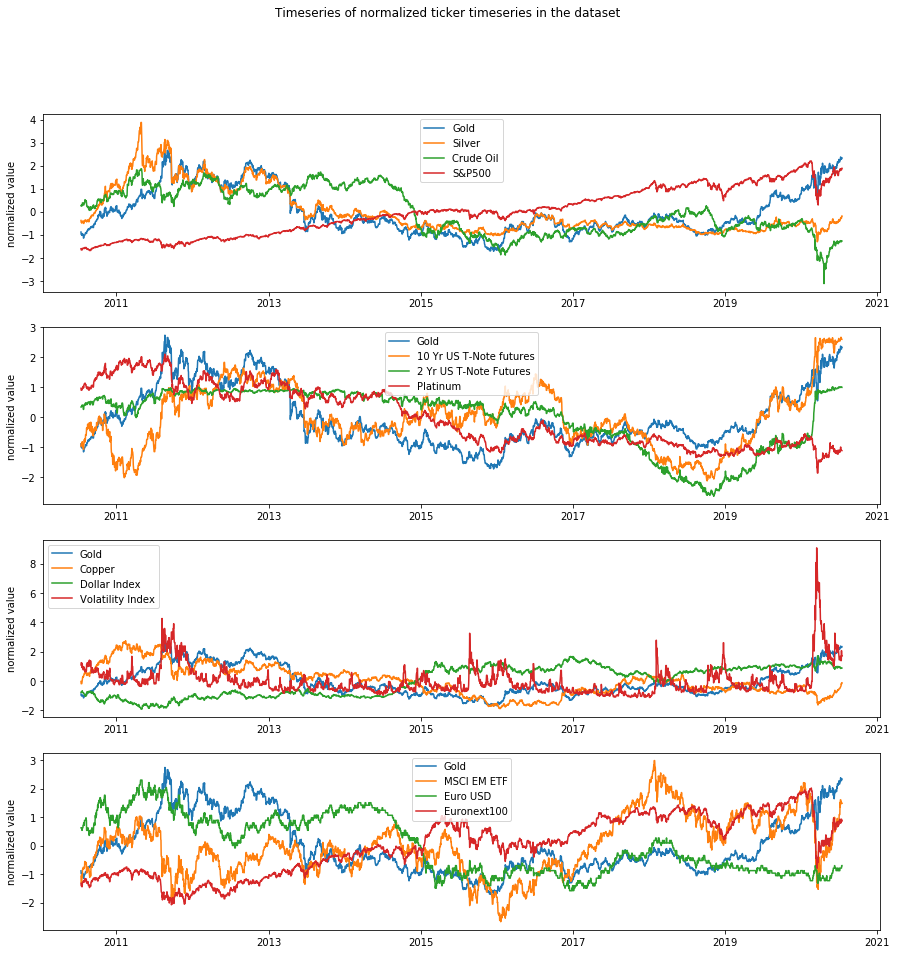

In [9]:
f, axes = plt.subplots(4, 1, figsize=(15,15))
f.suptitle("Timeseries of normalized ticker timeseries in the dataset")
for i in range(4):
    axes[i].plot(values['date'],(values['Gold']-np.mean(values['Gold']))/np.std(values['Gold']), label = 'Gold')
    for x in list(tickers.keys())[i*3+1:(i+1)*3+1]:
        axes[i].plot(values['date'],(values[x]-np.mean(values[x]))/np.std(values[x]), label = x)
    axes[i].legend()
    axes[i].set_ylabel("normalized value")

Histogram of the gold prices over the past 10 years show a bimodal pattern with 2 peaks one around 1300 USD and one around 1700 USD. skewness value shows that the data is moderately skewed.

Skewness: 0.738192
Kurtosis: -0.548557


/Users/ali.zonoozi/anaconda3/envs/scotia/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


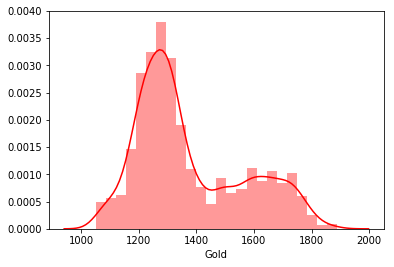

In [10]:
sns.distplot(values['Gold'], color = 'red')
print('Skewness: %f' %values['Gold'].skew())
print("Kurtosis: %f" % values['Gold'].kurt())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b7acef0>,
      dtype=object)

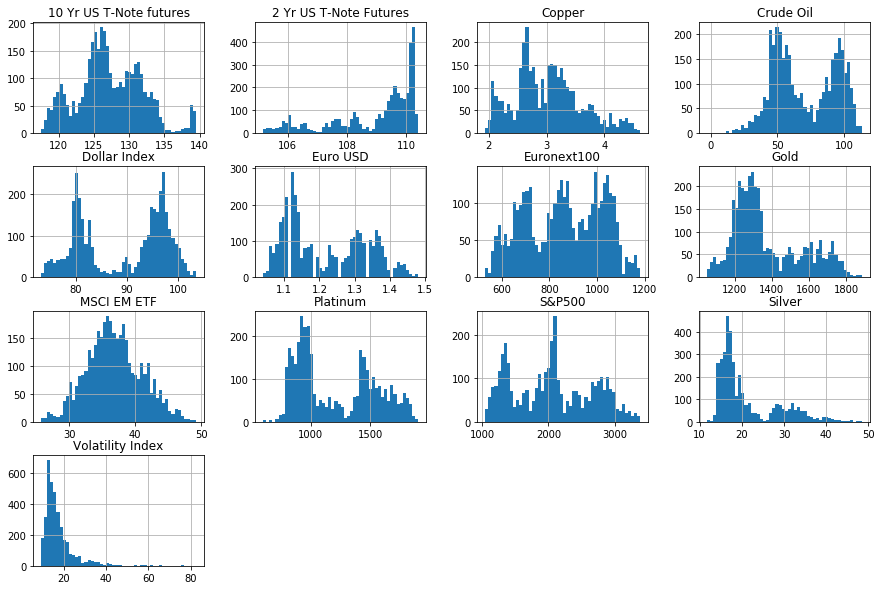

In [11]:
values.hist(bins=50, figsize=(15, 10))


## Correlation Analysis

Looking at the pair scatter plots gives us better understanding of correlations among different features. It is visible that some indicators are highly correlated (e.g. Dollar Index & EuroUSD) and including them in the model would hurn the model performance. So one of the highly correlated features need to be removed from the candidate features set.

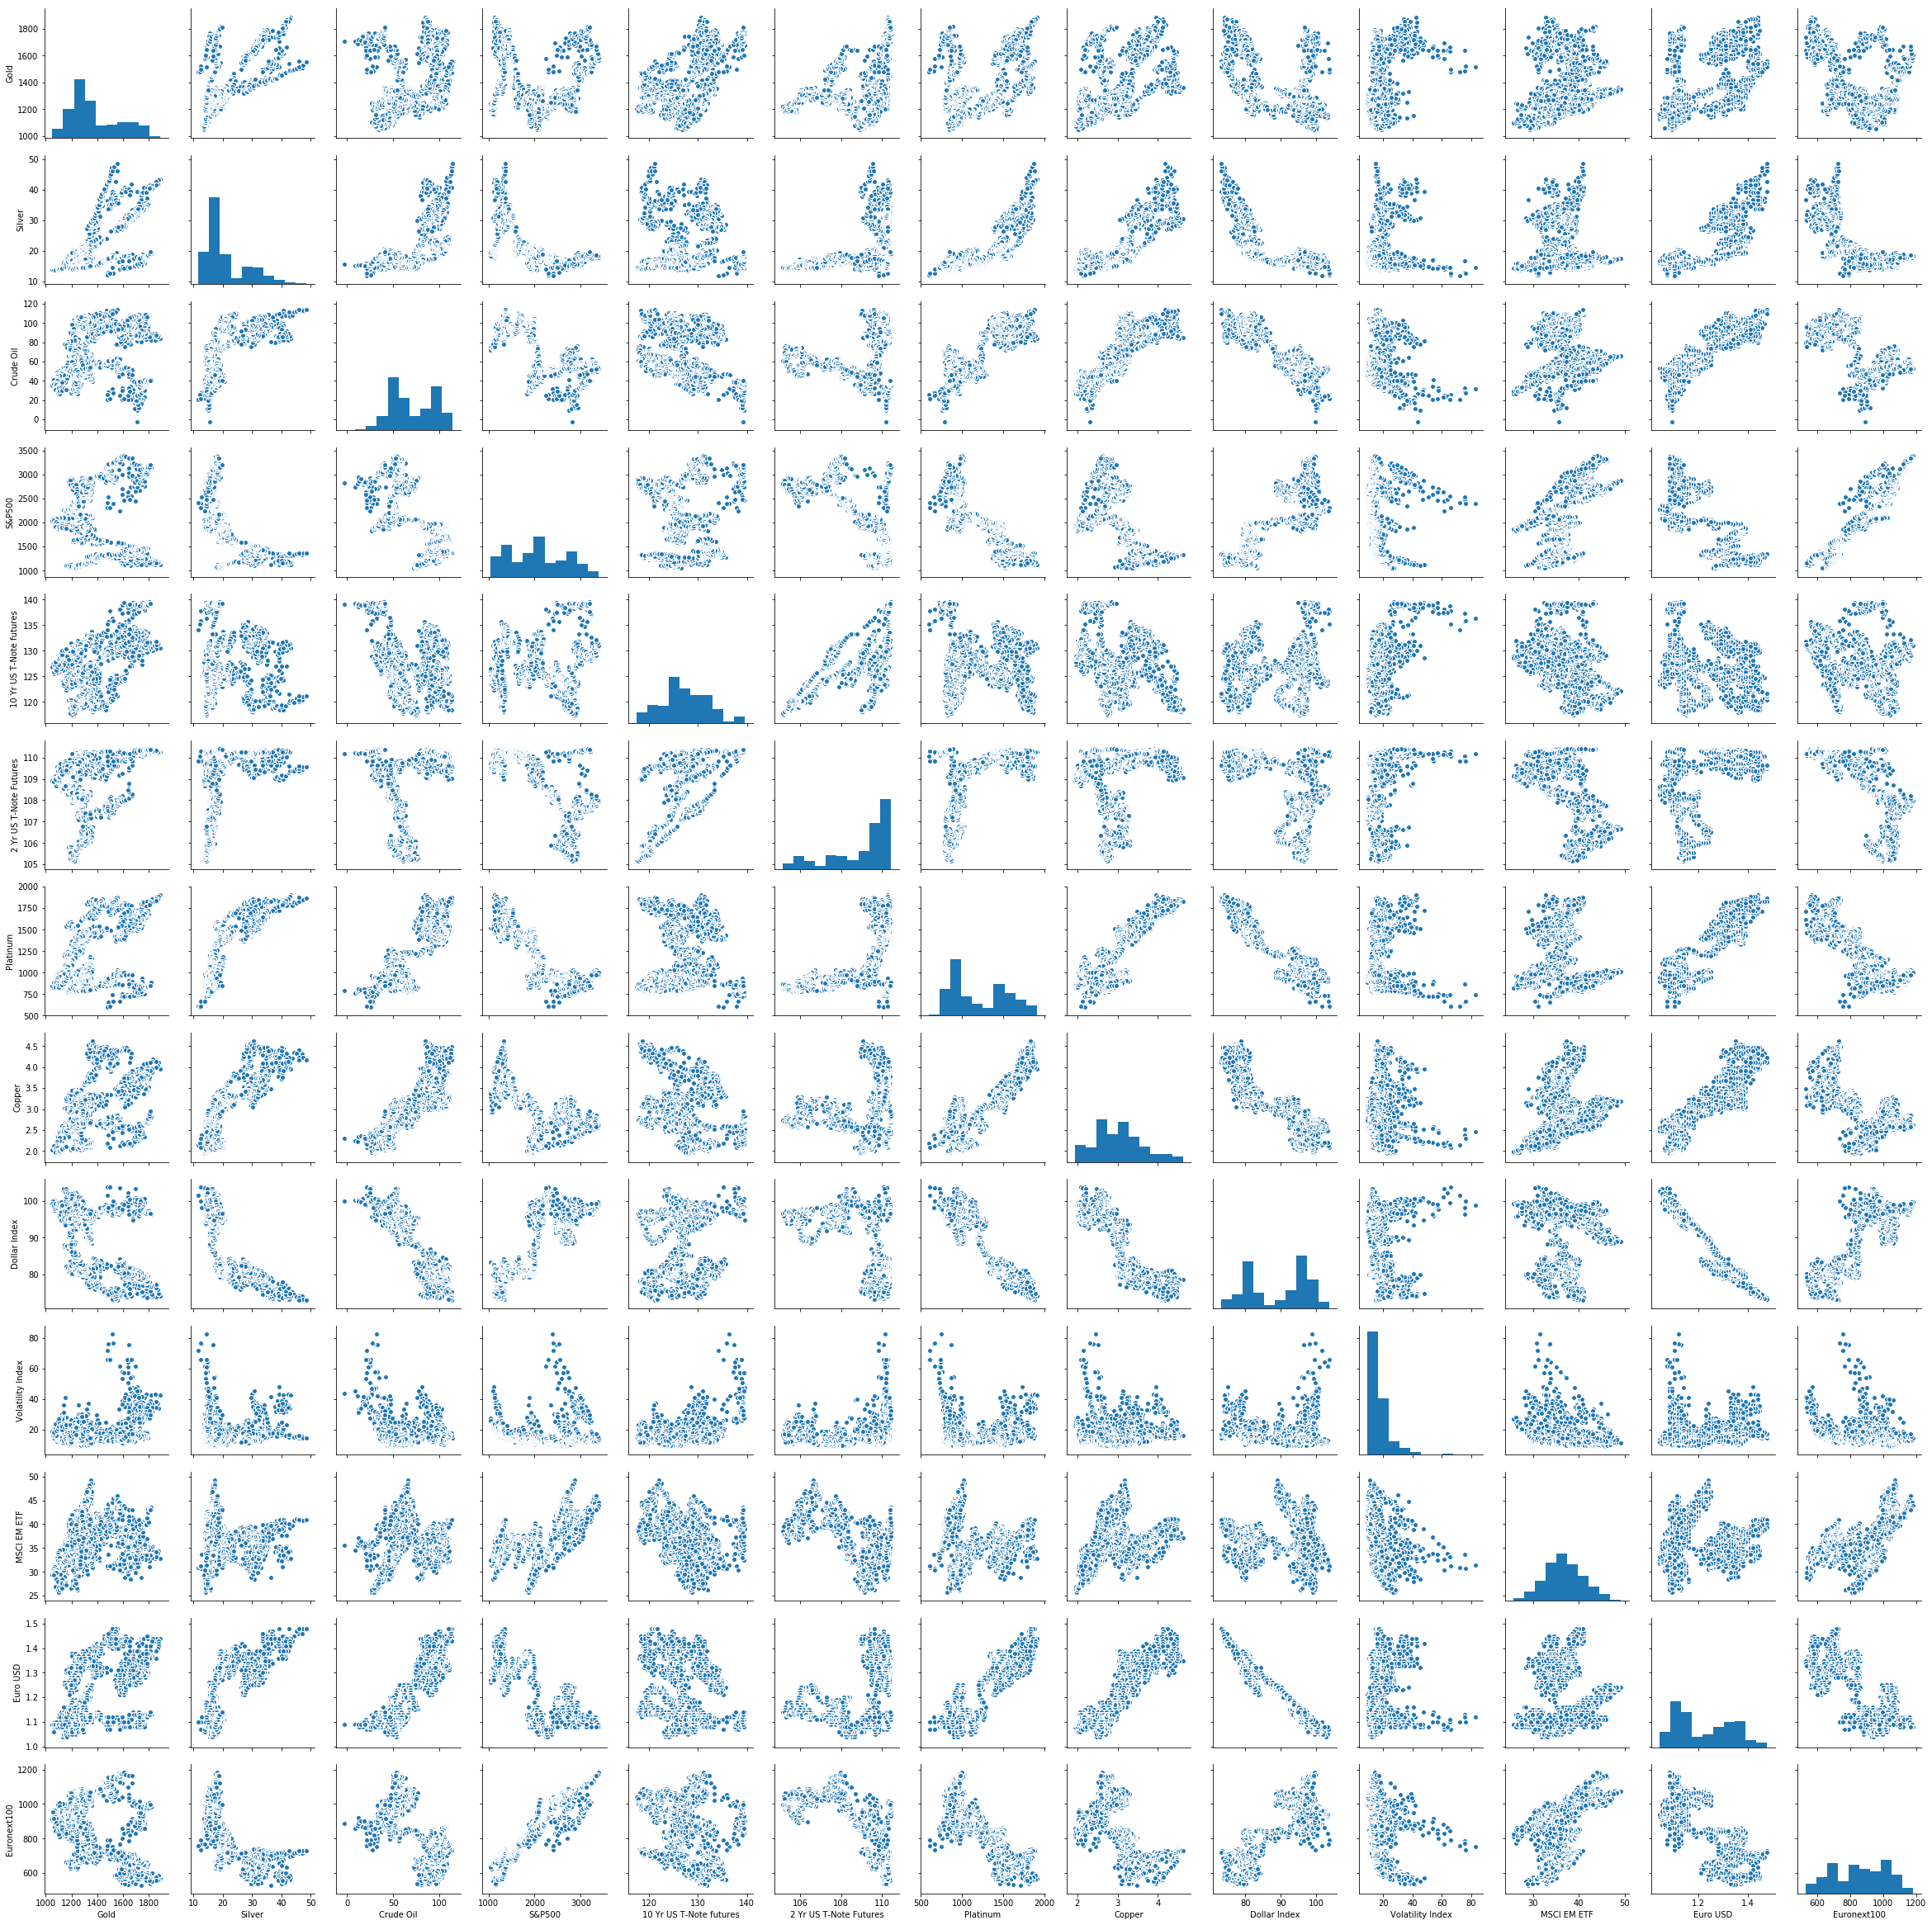

In [12]:
sns.pairplot(values.loc[:,values.dtypes == 'float64'])

The following heatmap plots provide the same information in a quantified fashion. We can see that and indicator such as Silver has correlation of 0.71 with the gold price, while MSCI EM has a low correlation.

Text(0.5,1.05,'Correlation of Features')

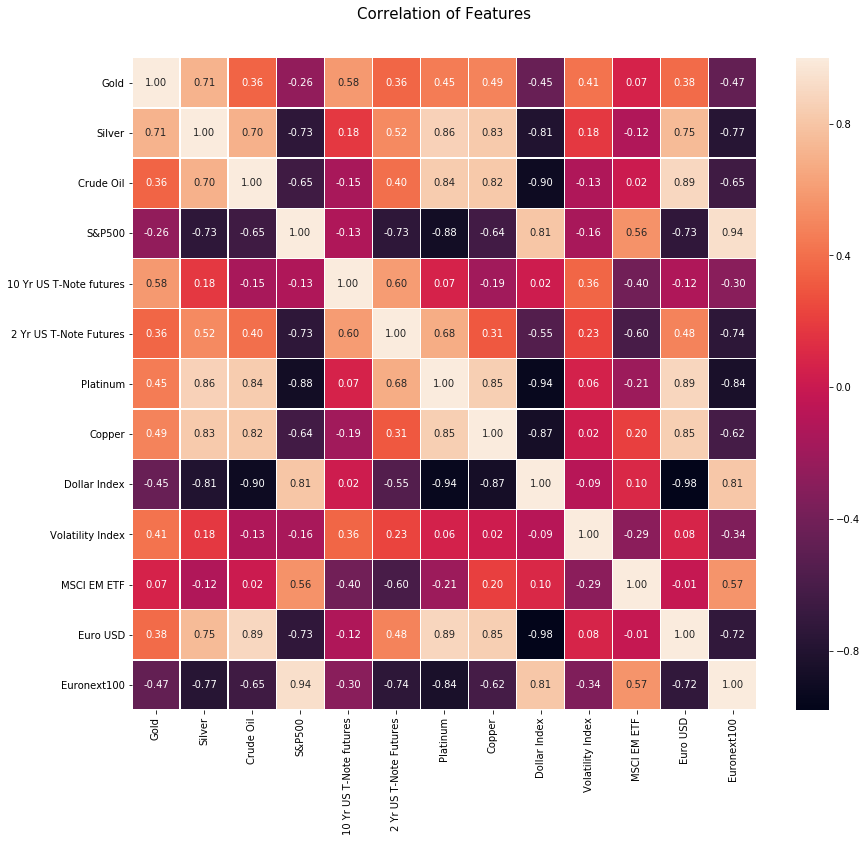

In [13]:
corr = values.corr()
plt.figure(figsize = (14,12))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,fmt='.2f',linewidths=0.30)
plt.title('Correlation of Features', y = 1.05, size=15)

In this step we remove one of the highly correlated features. A threshold=0.9 is used to identify highly correlated featues. Among 2 correlated featues the one thas has lower absolute correlation with Gold price is removed. In the following plot we can see the correlation heatmap after removing extra features.

corelated features to be removed: {'Euro USD', 'Crude Oil', 'S&P500', 'Dollar Index'}


Text(0.5,1.05,'Correlation of Features')

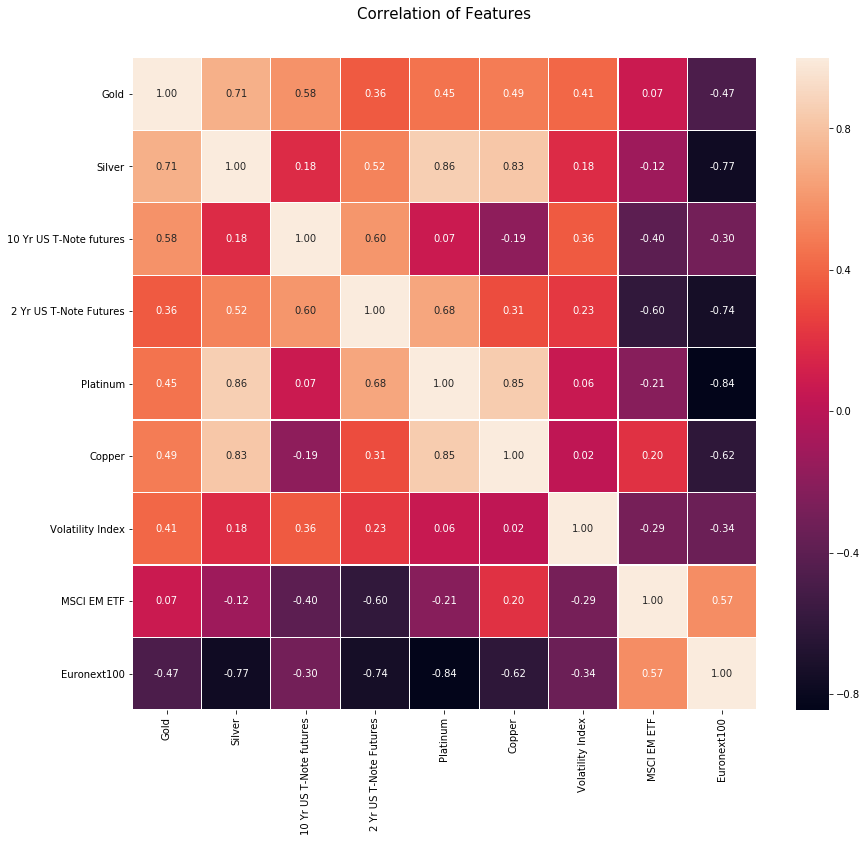

In [14]:
values = remove_correlated_features(values, corr, threshold=0.9)
corr = values.corr()
plt.figure(figsize = (14,12))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,fmt='.2f',linewidths=0.30)
plt.title('Correlation of Features', y = 1.05, size=15)

In [15]:
print(values.shape)
values.head()

(3654, 10)


date    Gold  Silver  10 Yr US T-Note futures  2 Yr US T-Note Futures  \
0 2010-07-15  1208.1   18.35                   122.78                  109.45   
1 2010-07-16  1188.0   17.77                   123.20                  109.47   
2 2010-07-17  1188.0   17.77                   123.20                  109.47   
3 2010-07-18  1188.0   17.77                   123.20                  109.47   
4 2010-07-19  1181.7   17.53                   123.03                  109.47   

   Platinum  Copper  Volatility Index  MSCI EM ETF  Euronext100  
0    1529.9    3.01             25.14        32.36       649.16  
1    1508.4    2.92             26.25        31.39       635.56  
2    1508.4    2.92             26.25        31.39       635.56  
3    1508.4    2.92             26.25        31.39       635.56  
4    1509.4    2.93             25.97        31.81       632.54

# Feature Engineering

The absolute values of price timeseries data are non-stationary and have differet scales which are not suitable as features for a model. Next step is to extract meaningful features from these indicators. For this purpose we need to extract different lagged effect to capture short-term and long term effect on the target variable. We are adding 5 types of features to out feature set:

* **Short-Term Rate of Change**: For all the available indicators, we add short-term rate of change with regards to the same date price. The rate of change is defines as $\frac{C(x) - C(x-n)}{C(x-n)}$ where C(x) is price on day x. ROC for lags of [1, 2, 3, 5, 7, 14, 21, 30] days are added to the feature set.
* **Long-Term Rate of Change**: For selected set of indicators with higher correlation with gold price, long term lags are extracted (2,3,6 months) and are added to the feature set.
* **ROC over Moving Average for Gold**: moving average are commonly used in timeseries data as it provides more stable signal changes over a moving window. We also add rate of change using simple moving average (windows of [15, 30, 60, 90, 180] days) and exponential moving average (windows of [30, 60, 90, 180] days) features to our feature set.
* **Stochastic Oscilators**: stochastic oscilators are indicators of over-bought of oversold stocks or commodities which can indicate a signal for market adjustments in near future. This values is calculated using the formula $ \frac{C(x)-L_n}{H_n-L_n}$ where C(X) is price on day x, $L_n$ is the lowest price over past n days and $H_n$ is the highest prices over past n days. We added this feature for highest correlated features, with n=14 days.
* **Ratio of $ROC_1$/$ROC_n$** As ROC gives us an indication price change going up and down, ratio of ROC can provide information on how the changes in prices are changing (similar to second order derivatives). For this purpose we calculate ratios for the past [2, 3, 5, 7, 14, 21] rate of changes.

Putting all the features togetger would give us 153 features in total. However many of them may not be useful. Using forward selection approach we can filter these features to gather a list of informative features for our model.

In [16]:
features = create_features(values)
features.tail()

date  Gold_t-1  Silver_t-1  10 Yr US T-Note futures_t-1  \
3469 2020-07-11  0.000000    0.000000                     0.000000   
3470 2020-07-12  0.000166    0.010549                    -0.001577   
3471 2020-07-13 -0.001219   -0.005741                    -0.000431   
3472 2020-07-14  0.006105    0.035171                    -0.000144   
3473 2020-07-15  0.000000    0.000000                     0.000000   

      2 Yr US T-Note Futures_t-1  Platinum_t-1  Copper_t-1  \
3469                    0.000000      0.000000    0.000000   
3470                    0.000091     -0.001535    0.028169   
3471                   -0.000091      0.000355   -0.006849   
3472                   -0.000181     -0.001655    0.020690   
3473                    0.000000      0.000000    0.000000   

      Volatility Index_t-1  MSCI EM ETF_t-1  Euronext100_t-1  \
3469              0.000000         0.000000         0.000000   
3470              0.000000         0.000000         0.000000   
3471              0.179553        -0.006707         0.014360   
3472             -0.082945         0.001397        -0.010407   
3473              0.000000         0.000000         0.000000   

                ...             Platinum_rocr_5  Platinum_rocr_7  \
3469            ...                    0.000000         0.000000   
3470            ...                   -0.162769        -0.064021   
3471            ...                   -0.017702         0.020632   
3472            ...                    0.037039        -0.203887   
3473            ...                   -0.000000        -0.000000   

      Platinum_rocr_14  Platinum_rocr_21  Volatility Index_rocr_2  \
3469          0.000000          0.000000                -0.000000   
3470         -0.043224         -0.067877                -0.000000   
3471          0.010927          0.015780                 1.000000   
3472         -0.084092         -1.745449                -1.015054   
3473         -0.000000         -0.000000                -0.000000   

      Volatility Index_rocr_3  Volatility Index_rocr_5  \
3469                -0.000000                -0.000000   
3470                -0.000000                -0.000000   
3471                 1.000000                 1.226727   
3472                -1.015054                -9.334504   
3473                 0.000000                 0.000000   

      Volatility Index_rocr_7  Volatility Index_rocr_14  \
3469                -0.000000                 -0.000000   
3470                -0.000000                 -0.000000   
3471                 1.180402                 13.917543   
3472               -27.123020                  2.773645   
3473                 0.000000                  0.000000   

      Volatility Index_rocr_21  
3469                 -0.000000  
3470                 -0.000000  
3471                 13.581898  
3472                  1.406478  
3473                 -0.000000  

[5 rows x 152 columns]

### Add target feature

In the last step we add the target variable to the dataset. For the target varibale we add the percentage change of gold price compared to n days ahead as the groundtruth.

In [17]:

y = pd.DataFrame(data=values['date'])
y['gold_target']=values['Gold'].pct_change(periods=-n_days_ahead)
features = pd.merge(left=features,right=y, on='date', how='left')
features = features.dropna()
features.shape


(3470, 153)

In [18]:
features.tail()

date  Gold_t-1  Silver_t-1  10 Yr US T-Note futures_t-1  \
3465 2020-07-07  0.001955    0.014192                    -0.000791   
3466 2020-07-08  0.009144    0.006459                     0.001583   
3467 2020-07-09  0.005912    0.024599                    -0.000072   
3468 2020-07-10 -0.009228   -0.010438                     0.002227   
3469 2020-07-11  0.000000    0.000000                     0.000000   

      2 Yr US T-Note Futures_t-1  Platinum_t-1  Copper_t-1  \
3465                   -0.000091      0.007335    0.007273   
3466                    0.000000      0.030440    0.010830   
3467                    0.000181      0.024096    0.007143   
3468                    0.000000     -0.041968    0.007092   
3469                    0.000000      0.000000    0.000000   

      Volatility Index_t-1  MSCI EM ETF_t-1  Euronext100_t-1     ...       \
3465              0.053329        -0.016690        -0.005367     ...        
3466             -0.045872         0.025931        -0.007690     ...        
3467              0.042023         0.000000        -0.009649     ...        
3468             -0.067327        -0.006434         0.008495     ...        
3469              0.000000         0.000000         0.000000     ...        

      Platinum_rocr_7  Platinum_rocr_14  Platinum_rocr_21  \
3465         0.639480         -1.031459          0.376711   
3466         2.159246          1.533621          1.331022   
3467         0.405363          0.244181          0.440995   
3468        -2.801470         -0.883630         -0.982325   
3469         0.000000          0.000000          0.000000   

      Volatility Index_rocr_2  Volatility Index_rocr_3  \
3465                 0.843505                 0.843505   
3466                -9.154653                -3.174312   
3467                -7.274887                 0.889482   
3468                 2.393106                 0.925909   
3469                -0.000000                -0.000000   

      Volatility Index_rocr_5  Volatility Index_rocr_7  \
3465                 0.843505                -1.622788   
3466                -3.174312                 2.431193   
3467                 0.736197                 0.736197   
3468                 4.778520                 4.778520   
3469                -0.000000                -0.000000   

      Volatility Index_rocr_14  Volatility Index_rocr_21  gold_target  
3465                 -0.862328                 -0.423484    -0.005710  
3466                  0.269495                  0.284846     0.003215  
3467                 -0.457424                 -0.376150     0.010378  
3468                  0.314285                  0.301984    -0.005020  
3469                 -0.000000                 -0.000000    -0.005020  

[5 rows x 153 columns]

## check target variable correlations

Text(0.5,0,'pearson correlation value')

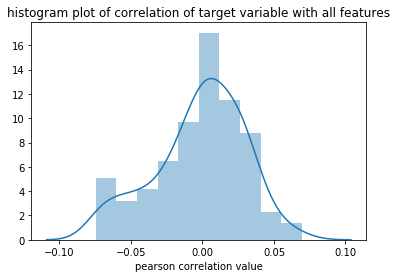

In [19]:
sns.distplot(features.corr()['gold_target'].values[:-1],)
plt.title("histogram plot of correlation of target variable with all features")
plt.xlabel("pearson correlation value")

# Model Training and Evaluation

For training the prediction model we need to split the dataset to training and validation sets. It is good practice to do cross-validations, however since our problem is time-series forecasting and we are more interested in predicting the most recent data, we can use hold-out validation where we consider the data before Jan 2018 for training and the data after that for validation and testing.

In [20]:
X_train = features[features['date'] < '2018-01-01'][features.columns[:-1]]
X_test = features[features['date'] >= '2018-01-01'][features.columns[:-1]]
y_train = features[features['date'] < '2018-01-01']['gold_target']
y_test = features[features['date'] >= '2018-01-01']['gold_target']

In [21]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2547, 152) (2547,)
(923, 152) (923,)


### Ordering features wrt correlation with Gold price

Now that we have the set of features at hand lets order them in order of their correlation to the target variable. Since we are using a greedy approach for feature selection, the goal here is that we avoid adding a less important feature in the first steps, while in the future a more important feature may be discarded because of some correlation with lesser important feature.

In [22]:
corr_sorted = sorted_correlations_with_gold(values.corr())
feature_columns = X_train.columns[1:].values
feature_columns_sorted = []


# add short term features
for val in corr_sorted.index:
    feature_columns_sorted.extend([x for x in feature_columns if (val in x and 't-' in x)])
# add long term features
for val in corr_sorted.index:
    feature_columns_sorted.extend([x for x in feature_columns if (val in x and 'months' in x)])
    
# add moving avg features
for val in corr_sorted.index:
    feature_columns_sorted.extend([x for x in feature_columns if (val in x and (('SMA' in x) or ('EMA' in x)))])
len(feature_columns_sorted)

    
# add roc ratio features
for val in corr_sorted.index:
    feature_columns_sorted.extend([x for x in feature_columns if (val in x and 'rocr' in x)])

# add osc features
for val in corr_sorted.index:
    feature_columns_sorted.extend([x for x in feature_columns if (val in x and 'osc' in x)])
    


In [23]:
assert len(feature_columns_sorted) == len(features.columns)-2

## Feature Selection 

For the model choice we are considering a linear model e.g. **Linear Regression** and a non-linear model e.g. **gradient boosting trees (XGBoost)** as candidates. We would like to see which model would be able to minimize the loss and bias and variance errors on the validation set.

### Holdout Validation [Linear Regression]

In the first step we do not discard any feature from the model. We add the features one by one and train the model on those features and capture the training and validation losses.

In [26]:
used_features = []
max_score = -np.inf
validation_scores, training_scores, n_features_used = [],[],[]
validation_loss, training_loss = [],[]
for f in feature_columns_sorted:
    print("adding feature %s"%f)
    used_features.append(f)
    lr = LinearRegression()
    model = lr.fit(X=X_train[used_features],y=y_train.values)
    y_pred = model.predict(X_test[used_features])
    score = r2_score(y_test,y_pred)
    validation_scores.append(score)
    validation_loss.append(mean_squared_error(y_test,y_pred))
    y_pred_train = model.predict(X_train[used_features])
    score_train = r2_score(y_train,y_pred_train)
    training_scores.append(score_train)
    training_loss.append(mean_squared_error(y_train,y_pred_train))
    if score > max_score:
        print("r2 score increased")
        max_score = score

    print("validation loss: %.8f"%score, end="\t")
    print("training score: %.8f"%score_train, end="\t")
    print("max score: %.5f"%max_score)
    n_features_used.append(len(used_features))
    print('-'*80)

adding feature Gold_t-1
r2 score increased
validation score: -0.00979	training score: 0.00008	max score: -0.00979
--------------------------------------------------------------------------------
adding feature Gold_t-2
validation score: -0.01034	training score: 0.00045	max score: -0.00979
--------------------------------------------------------------------------------
adding feature Gold_t-3
r2 score increased
validation score: -0.00976	training score: 0.00065	max score: -0.00976
--------------------------------------------------------------------------------
adding feature Gold_t-5
validation score: -0.02024	training score: 0.00153	max score: -0.00976
--------------------------------------------------------------------------------
adding feature Gold_t-7
validation score: -0.03152	training score: 0.00223	max score: -0.00976
--------------------------------------------------------------------------------
adding feature Gold_t-14
validation score: -0.03376	training score: 0.00239	max sc

validation score: -0.04180	training score: 0.05818	max score: 0.01965
--------------------------------------------------------------------------------
adding feature Platinum_t-21
validation score: -0.03434	training score: 0.05881	max score: 0.01965
--------------------------------------------------------------------------------
adding feature Platinum_t-30
validation score: -0.03260	training score: 0.05910	max score: 0.01965
--------------------------------------------------------------------------------
adding feature Volatility Index_t-1
validation score: -0.03336	training score: 0.05935	max score: 0.01965
--------------------------------------------------------------------------------
adding feature Volatility Index_t-2
validation score: -0.03323	training score: 0.05973	max score: 0.01965
--------------------------------------------------------------------------------
adding feature Volatility Index_t-3
validation score: -0.03438	training score: 0.05995	max score: 0.01965
---------

validation score: -0.29779	training score: 0.11690	max score: 0.01965
--------------------------------------------------------------------------------
adding feature Gold_60SMA
validation score: -0.30555	training score: 0.11738	max score: 0.01965
--------------------------------------------------------------------------------
adding feature Gold_90SMA
validation score: -0.30889	training score: 0.11765	max score: 0.01965
--------------------------------------------------------------------------------
adding feature Gold_180SMA
validation score: -0.31427	training score: 0.12122	max score: 0.01965
--------------------------------------------------------------------------------
adding feature Gold_30EMA
validation score: -0.31797	training score: 0.12136	max score: 0.01965
--------------------------------------------------------------------------------
adding feature Gold_60EMA
validation score: -0.31925	training score: 0.12153	max score: 0.01965
--------------------------------------------

validation score: -0.44256	training score: 0.14303	max score: 0.01965
--------------------------------------------------------------------------------
adding feature Gold_osc
validation score: -0.44100	training score: 0.14506	max score: 0.01965
--------------------------------------------------------------------------------
adding feature Silver_osc
validation score: -0.45220	training score: 0.14711	max score: 0.01965
--------------------------------------------------------------------------------
adding feature 10 Yr US T-Note futures_osc
validation score: -0.47025	training score: 0.14932	max score: 0.01965
--------------------------------------------------------------------------------
adding feature Copper_osc
validation score: -0.48366	training score: 0.15006	max score: 0.01965
--------------------------------------------------------------------------------
adding feature Euronext100_osc
validation score: -0.50003	training score: 0.15080	max score: 0.01965
-------------------------

As more features are added to the linear regression model we see that the training loss keeps decreasing while the validation loss keeps increasing. This is expected as we are not discarding any feature, so overfitting occurs as more features are added to the model

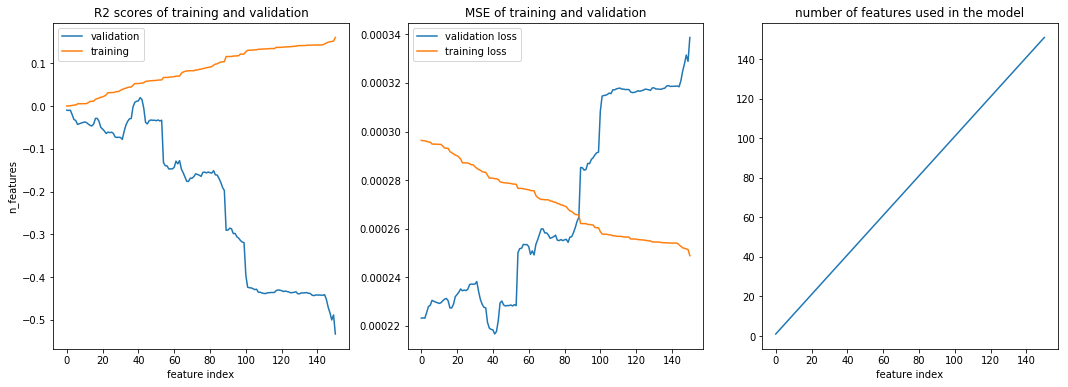

In [28]:
create_lr_plot(validation_scores,training_scores,validation_loss,training_loss,n_features_used)

This time let's add each feature one by one and monitor the score on validation set. We only keep the feature if it
improves the score, otherwise the feature is discarded.

In [29]:
useful_features = []
max_score = -np.inf
validation_scores, training_scores, n_features_used = [],[],[]
validation_loss, training_loss = [],[]
for f in feature_columns_sorted:
    print("adding feature %s"%f)
    useful_features.append(f)
    lr = LinearRegression()
    model = lr.fit(X=X_train[useful_features],y=y_train.values)
    y_pred = model.predict(X_test[useful_features])
    score = r2_score(y_test,y_pred)
    validation_scores.append(score)
    validation_loss.append(mean_squared_error(y_test,y_pred))
    y_pred_train = model.predict(X_train[useful_features])
    score_train = r2_score(y_train,y_pred_train)
    training_scores.append(score_train)
    training_loss.append(mean_squared_error(y_train,y_pred_train))
    if score > max_score:
        print("r2 score increased")
        max_score = score
    else:
        print('r2 score did not increase. removing feature %s'%f)
        useful_features.remove(f)
    print("validation score: %.5f"%score, end="\t")
    print("training score: %.5f"%score_train,end="\t")
    print("max score: %.5f"%max_score)
    n_features_used.append(len(useful_features))
    print('-'*80)

adding feature Gold_t-1
r2 score increased
validation score: -0.00979	training score: 0.00008	max score: -0.00979
--------------------------------------------------------------------------------
adding feature Gold_t-2
r2 score did not increase. removing feature Gold_t-2
validation score: -0.01034	training score: 0.00045	max score: -0.00979
--------------------------------------------------------------------------------
adding feature Gold_t-3
r2 score increased
validation score: -0.00956	training score: 0.00063	max score: -0.00956
--------------------------------------------------------------------------------
adding feature Gold_t-5
r2 score did not increase. removing feature Gold_t-5
validation score: -0.02013	training score: 0.00152	max score: -0.00956
--------------------------------------------------------------------------------
adding feature Gold_t-7
r2 score did not increase. removing feature Gold_t-7
validation score: -0.03151	training score: 0.00222	max score: -0.00956
----

r2 score did not increase. removing feature Volatility Index_t-2
validation score: 0.07326	training score: 0.01983	max score: 0.07397
--------------------------------------------------------------------------------
adding feature Volatility Index_t-3
r2 score increased
validation score: 0.07475	training score: 0.01917	max score: 0.07475
--------------------------------------------------------------------------------
adding feature Volatility Index_t-5
r2 score did not increase. removing feature Volatility Index_t-5
validation score: 0.07369	training score: 0.01992	max score: 0.07475
--------------------------------------------------------------------------------
adding feature Volatility Index_t-7
r2 score did not increase. removing feature Volatility Index_t-7
validation score: 0.07123	training score: 0.02033	max score: 0.07475
--------------------------------------------------------------------------------
adding feature Volatility Index_t-14
r2 score did not increase. removing featu

r2 score did not increase. removing feature Gold_30EMA
validation score: 0.06088	training score: 0.03214	max score: 0.09934
--------------------------------------------------------------------------------
adding feature Gold_60EMA
r2 score did not increase. removing feature Gold_60EMA
validation score: 0.09842	training score: 0.02397	max score: 0.09934
--------------------------------------------------------------------------------
adding feature Gold_90EMA
r2 score did not increase. removing feature Gold_90EMA
validation score: 0.09749	training score: 0.02632	max score: 0.09934
--------------------------------------------------------------------------------
adding feature Gold_180EMA
r2 score did not increase. removing feature Gold_180EMA
validation score: 0.09043	training score: 0.02765	max score: 0.09934
--------------------------------------------------------------------------------
adding feature Gold_rocr_2
r2 score increased
validation score: 0.09957	training score: 0.02416	max 

r2 score did not increase. removing feature Volatility Index_rocr_3
validation score: 0.10327	training score: 0.02595	max score: 0.10413
--------------------------------------------------------------------------------
adding feature Volatility Index_rocr_5
r2 score did not increase. removing feature Volatility Index_rocr_5
validation score: 0.10399	training score: 0.02556	max score: 0.10413
--------------------------------------------------------------------------------
adding feature Volatility Index_rocr_7
r2 score increased
validation score: 0.10421	training score: 0.02560	max score: 0.10421
--------------------------------------------------------------------------------
adding feature Volatility Index_rocr_14
r2 score did not increase. removing feature Volatility Index_rocr_14
validation score: 0.10404	training score: 0.02560	max score: 0.10421
--------------------------------------------------------------------------------
adding feature Volatility Index_rocr_21
r2 score did not i

After training on various number of features while discarding the low performing ones. we can see that around 50 features are used in the final model. However, as we are monitoring validation loss not to go up, we see that the training loss does not decrease as much. This shows that the model has high bias with this number of features and is ntot able to explain the variations in the training set even with higher number of features.

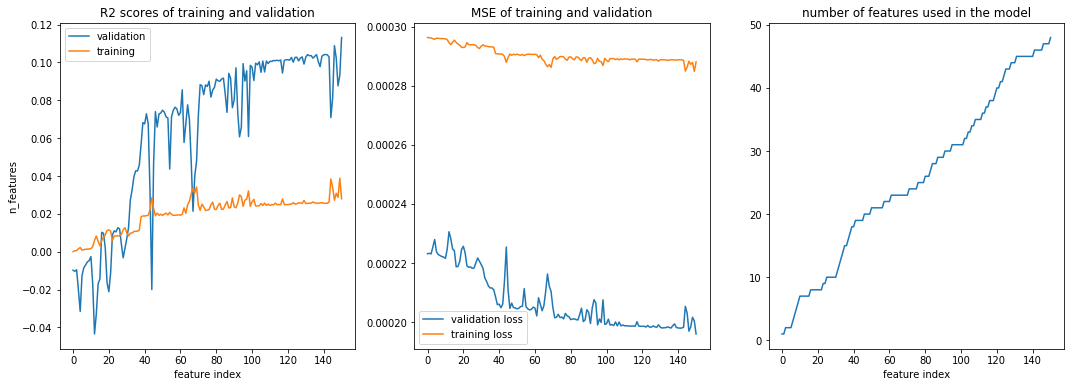

In [30]:
create_lr_plot(validation_scores,training_scores,validation_loss,training_loss,n_features_used)

## Feature Selection [XGBoost]

### Holdout Validation [XGB]

Since the linear regression was not able to model the data well, we shift our focus to XGBoost model as a non-linear model. XGBoost is a gradient boosting decision tree which has high performance. Similar to the linear regression approach, first we add all the features to the model without discarding them to see how training and validation losses would change.

In [31]:
used_features = []
min_score = np.inf
validation_scores, training_scores, n_features_used = [],[],[]
for f in feature_columns_sorted:
    print("adding feature %s"%f)
    used_features.append(f)
#    print("feature list",useful_features)
    xg = xgb.XGBRegressor(max_depth=3,objective='reg:squarederror')
    model = xg.fit(X=X_train[used_features],y=y_train.values)
    y_pred = model.predict(X_test[used_features])
    score = mean_squared_error(y_test,y_pred)
    validation_scores.append(score)
    y_pred_train = model.predict(X_train[used_features])
    score_train = mean_squared_error(y_train,y_pred_train)
    training_scores.append(score_train)
    if score < min_score:
        print("mse loss decreased. score: %.8f" %score)
        min_score = score

    print("validation loss: %.8f"%score, end="\t")
    print("training loss: %.8f"%score_train,end="\t")
    print("min loss: %.8f"%min_score)
    n_features_used.append(len(used_features))
    print('-'*80)
    
xg = xgb.XGBRegressor(max_depth=3,objective='reg:squarederror')
model = xg.fit(X=X_train[useful_features],y=y_train.values)
y_pred = model.predict(X_test[useful_features])
score = mean_squared_error(y_test,y_pred)
print("final score: %.5f"%score)

adding feature Gold_t-1
mse loss decreased. score: 0.00022707
validation loss: 0.00022707	training loss: 0.00027212	min loss: 0.00022707
--------------------------------------------------------------------------------
adding feature Gold_t-2
validation loss: 0.00023068	training loss: 0.00026420	min loss: 0.00022707
--------------------------------------------------------------------------------
adding feature Gold_t-3
validation loss: 0.00023193	training loss: 0.00025759	min loss: 0.00022707
--------------------------------------------------------------------------------
adding feature Gold_t-5
validation loss: 0.00023463	training loss: 0.00024776	min loss: 0.00022707
--------------------------------------------------------------------------------
adding feature Gold_t-7
mse loss decreased. score: 0.00022661
validation loss: 0.00022661	training loss: 0.00023984	min loss: 0.00022661
--------------------------------------------------------------------------------
adding feature Gold_t-14

validation loss: 0.00025854	training loss: 0.00017613	min loss: 0.00022624
--------------------------------------------------------------------------------
adding feature Platinum_t-14
validation loss: 0.00026197	training loss: 0.00017339	min loss: 0.00022624
--------------------------------------------------------------------------------
adding feature Platinum_t-21
validation loss: 0.00025928	training loss: 0.00017842	min loss: 0.00022624
--------------------------------------------------------------------------------
adding feature Platinum_t-30
validation loss: 0.00026310	training loss: 0.00017039	min loss: 0.00022624
--------------------------------------------------------------------------------
adding feature Volatility Index_t-1
validation loss: 0.00026099	training loss: 0.00017323	min loss: 0.00022624
--------------------------------------------------------------------------------
adding feature Volatility Index_t-2
validation loss: 0.00026374	training loss: 0.00017035	min los

validation loss: 0.00029820	training loss: 0.00014855	min loss: 0.00022624
--------------------------------------------------------------------------------
adding feature Platinum_3months
validation loss: 0.00030506	training loss: 0.00015143	min loss: 0.00022624
--------------------------------------------------------------------------------
adding feature Platinum_6months
validation loss: 0.00030781	training loss: 0.00014638	min loss: 0.00022624
--------------------------------------------------------------------------------
adding feature Volatility Index_2months
validation loss: 0.00030537	training loss: 0.00014600	min loss: 0.00022624
--------------------------------------------------------------------------------
adding feature Volatility Index_3months
validation loss: 0.00030416	training loss: 0.00014840	min loss: 0.00022624
--------------------------------------------------------------------------------
adding feature Volatility Index_6months
validation loss: 0.00030111	training

validation loss: 0.00031770	training loss: 0.00014329	min loss: 0.00022624
--------------------------------------------------------------------------------
adding feature Platinum_rocr_2
validation loss: 0.00031770	training loss: 0.00014329	min loss: 0.00022624
--------------------------------------------------------------------------------
adding feature Platinum_rocr_3
validation loss: 0.00032363	training loss: 0.00014395	min loss: 0.00022624
--------------------------------------------------------------------------------
adding feature Platinum_rocr_5
validation loss: 0.00032027	training loss: 0.00014578	min loss: 0.00022624
--------------------------------------------------------------------------------
adding feature Platinum_rocr_7
validation loss: 0.00032027	training loss: 0.00014578	min loss: 0.00022624
--------------------------------------------------------------------------------
adding feature Platinum_rocr_14
validation loss: 0.00032473	training loss: 0.00014667	min loss: 

Again we see that as the number of features are increased the training loss decreases and validation loss increases which shows overfitting pattern. We need to go throught he features again one by one and select the features that decrease the loss.

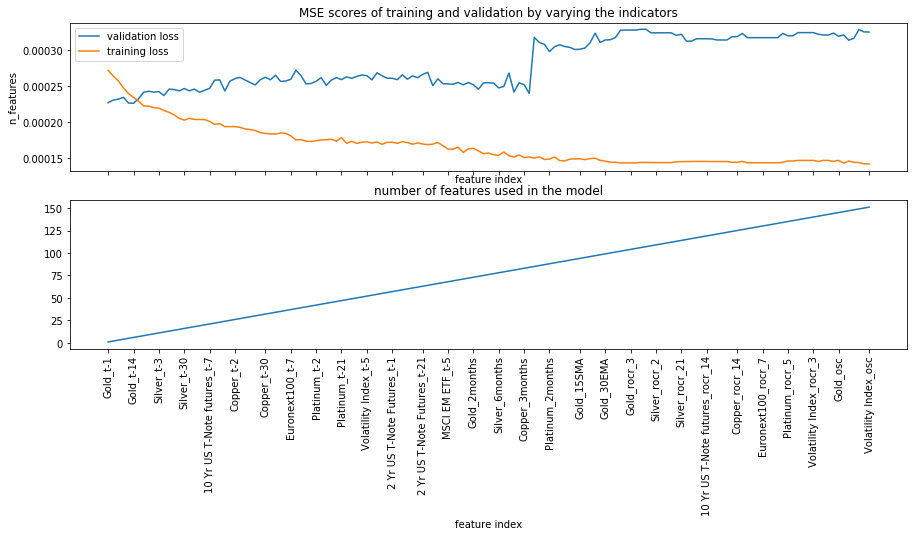

In [32]:
create_xgb_plot(validation_scores,training_scores,n_features_used,feature_columns_sorted)

This time let's add each feature one by one and monitor the score on validation set. We only keep the feature if its improves the score, otherwise the feature is discarded.

In [33]:
useful_features = []
min_score = np.inf
validation_scores, training_scores, n_features_used = [],[],[]
for f in feature_columns_sorted:
    print("adding feature %s"%f)
    useful_features.append(f)
#    print("feature list",useful_features)
    xg = xgb.XGBRegressor(max_depth=3,objective='reg:squarederror')
    model = xg.fit(X=X_train[useful_features],y=y_train.values)
    y_pred = model.predict(X_test[useful_features])
    score = mean_squared_error(y_test,y_pred)
    validation_scores.append(score)
    y_pred_train = model.predict(X_train[useful_features])
    score_train = mean_squared_error(y_train,y_pred_train)
    training_scores.append(score_train)
    if score < min_score:
        print("mse loss decreased. score: %.8f" %score)
        min_score = score
    else:
        print('mse loss did not decrease. removing feature')
        useful_features.remove(f)
    print("validation loss: %.8f"%score, end="\t")
    print("training loss: %.8f"%score_train, end="\t")
    print("min loss: %.8f"%min_score)
    n_features_used.append(len(useful_features))
    print('-'*80)
    
xg = xgb.XGBRegressor(max_depth=3,objective='reg:squarederror')
model = xg.fit(X=X_train[useful_features],y=y_train.values)
y_pred = model.predict(X_test[useful_features])
score = mean_squared_error(y_test,y_pred)
print("final score: %.5f"%score)

adding feature Gold_t-1
mse loss decreased. score: 0.00022707
validation loss: 0.00022707	training loss: 0.00027212	min loss: 0.00022707
--------------------------------------------------------------------------------
adding feature Gold_t-2
mse loss did not decrease. removing feature
validation loss: 0.00023068	training loss: 0.00026420	min loss: 0.00022707
--------------------------------------------------------------------------------
adding feature Gold_t-3
mse loss did not decrease. removing feature
validation loss: 0.00023336	training loss: 0.00026428	min loss: 0.00022707
--------------------------------------------------------------------------------
adding feature Gold_t-5
mse loss did not decrease. removing feature
validation loss: 0.00023302	training loss: 0.00025795	min loss: 0.00022707
--------------------------------------------------------------------------------
adding feature Gold_t-7
mse loss decreased. score: 0.00022265
validation loss: 0.00022265	training loss: 0.000

mse loss did not decrease. removing feature
validation loss: 0.00024024	training loss: 0.00022776	min loss: 0.00020238
--------------------------------------------------------------------------------
adding feature Euronext100_t-14
mse loss did not decrease. removing feature
validation loss: 0.00022659	training loss: 0.00022497	min loss: 0.00020238
--------------------------------------------------------------------------------
adding feature Euronext100_t-21
mse loss did not decrease. removing feature
validation loss: 0.00021429	training loss: 0.00022264	min loss: 0.00020238
--------------------------------------------------------------------------------
adding feature Euronext100_t-30
mse loss did not decrease. removing feature
validation loss: 0.00021670	training loss: 0.00022532	min loss: 0.00020238
--------------------------------------------------------------------------------
adding feature Platinum_t-1
mse loss did not decrease. removing feature
validation loss: 0.00020668	trai

mse loss did not decrease. removing feature
validation loss: 0.00020240	training loss: 0.00021208	min loss: 0.00019329
--------------------------------------------------------------------------------
adding feature Gold_3months
mse loss did not decrease. removing feature
validation loss: 0.00020409	training loss: 0.00020790	min loss: 0.00019329
--------------------------------------------------------------------------------
adding feature Gold_6months
mse loss did not decrease. removing feature
validation loss: 0.00020934	training loss: 0.00020788	min loss: 0.00019329
--------------------------------------------------------------------------------
adding feature Silver_2months
mse loss did not decrease. removing feature
validation loss: 0.00020414	training loss: 0.00021178	min loss: 0.00019329
--------------------------------------------------------------------------------
adding feature Silver_3months
mse loss did not decrease. removing feature
validation loss: 0.00020412	training los

mse loss did not decrease. removing feature
validation loss: 0.00020454	training loss: 0.00021995	min loss: 0.00019329
--------------------------------------------------------------------------------
adding feature Silver_rocr_3
mse loss did not decrease. removing feature
validation loss: 0.00019609	training loss: 0.00021832	min loss: 0.00019329
--------------------------------------------------------------------------------
adding feature Silver_rocr_5
mse loss did not decrease. removing feature
validation loss: 0.00019553	training loss: 0.00021958	min loss: 0.00019329
--------------------------------------------------------------------------------
adding feature Silver_rocr_7
mse loss did not decrease. removing feature
validation loss: 0.00020383	training loss: 0.00022074	min loss: 0.00019329
--------------------------------------------------------------------------------
adding feature Silver_rocr_14
mse loss did not decrease. removing feature
validation loss: 0.00019888	training lo

mse loss did not decrease. removing feature
validation loss: 0.00019662	training loss: 0.00022131	min loss: 0.00019180
--------------------------------------------------------------------------------
adding feature Silver_osc
mse loss did not decrease. removing feature
validation loss: 0.00019863	training loss: 0.00022079	min loss: 0.00019180
--------------------------------------------------------------------------------
adding feature 10 Yr US T-Note futures_osc
mse loss did not decrease. removing feature
validation loss: 0.00020582	training loss: 0.00021986	min loss: 0.00019180
--------------------------------------------------------------------------------
adding feature Copper_osc
mse loss did not decrease. removing feature
validation loss: 0.00019624	training loss: 0.00021949	min loss: 0.00019180
--------------------------------------------------------------------------------
adding feature Euronext100_osc
mse loss did not decrease. removing feature
validation loss: 0.00020146	tr

In [34]:
print("mean squared error: %.8f" %min_score)
print("root mean squared error: %.8f" %np.sqrt(min_score))

mean squared error: 0.00019180
root mean squared error: 0.01384921


Using Xgboost model we se that around 13 features are added to the model in total. Also both training and validation loss show decreasing patterns and the loss values is lower than the linear regression model one. Therefore, we select these features as our final set of features for model training purpose.

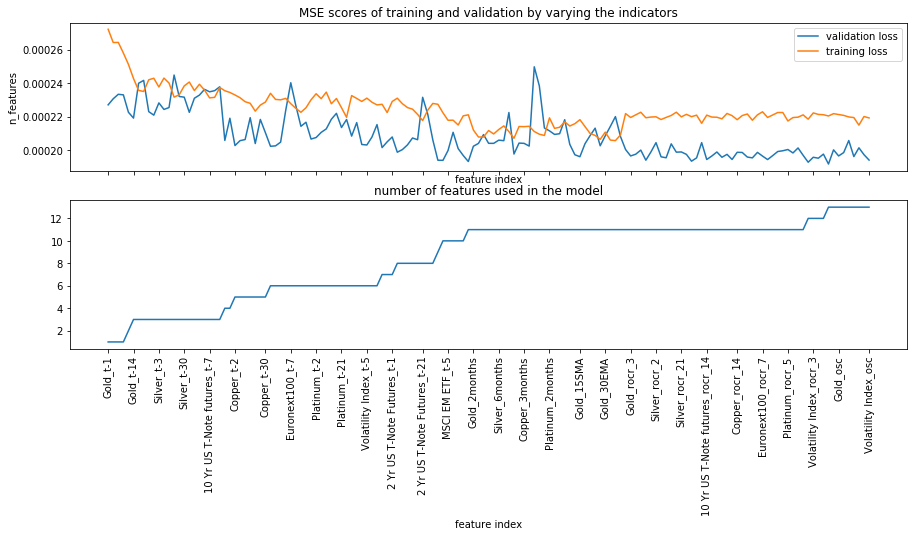

In [35]:
create_xgb_plot(validation_scores,training_scores,n_features_used,feature_columns_sorted)

Here we are visializing the target variable groundtruth and model prediction on the validation set

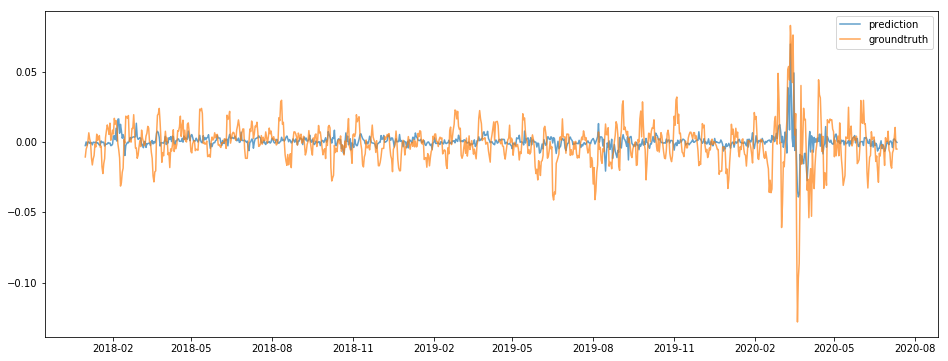

In [36]:

plt.figure(figsize=(16,6))
plt.plot(X_test['date'],y_pred, label='prediction',alpha=0.7)
plt.plot(X_test['date'],y_test.values, label='groundtruth',alpha=0.7)
plt.legend()

In [37]:
df_predict = pd.DataFrame()
df_predict['date'] = X_test['date']
df_predict['return_prediction'] = y_pred


In [38]:
results = pd.DataFrame()
results['date']  = pd.date_range(start='2018-01-01', end= values['date'].iloc[-1])
results = pd.merge(left=results, right=values[['date','Gold']], on='date', how='left')
results = pd.merge(left=results, right=df_predict[['date','return_prediction']], on='date', how='left')
results ['predicted_price'] = results['Gold']*(results ['return_prediction']+1)
results ['predicted_price'] = results ['predicted_price'].shift(n_days_ahead)
results.tail(10)

date    Gold  return_prediction  predicted_price
917 2020-07-06  1790.0          -0.003882      1776.617460
918 2020-07-07  1793.5           0.001690      1780.686341
919 2020-07-08  1809.9           0.002241      1781.211701
920 2020-07-09  1820.6           0.001416      1785.996446
921 2020-07-10  1803.8           0.000276      1783.051236
922 2020-07-11  1803.8          -0.000214      1796.531069
923 2020-07-12  1804.1                NaN      1813.956661
924 2020-07-13  1801.9                NaN      1823.177477
925 2020-07-14  1812.9                NaN      1804.298009
926 2020-07-15  1812.9                NaN      1803.413484

Let's visualize gold price prediction vs groundtruth based on the predicted returns

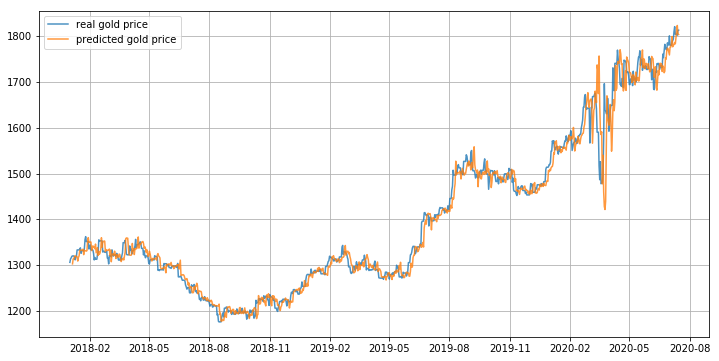

In [39]:
plt.figure(figsize=(12,6))
plt.plot(results['date'], results['Gold'], label="real gold price",alpha=0.8)
plt.plot(results['date'], results['predicted_price'], label="predicted gold price",alpha=0.8)
plt.grid()
plt.legend()

In [40]:
pd.DataFrame({"feature":useful_features,"importance":xg.feature_importances_})

feature  importance
0                       Gold_t-1    0.044382
1                       Gold_t-7    0.106904
2                      Gold_t-14    0.092802
3   10 Yr US T-Note futures_t-30    0.098256
4                     Copper_t-2    0.079103
5                Euronext100_t-1    0.086310
6          Volatility Index_t-21    0.090727
7     2 Yr US T-Note Futures_t-2    0.062351
8                MSCI EM ETF_t-2    0.084684
9                MSCI EM ETF_t-3    0.103036
10              MSCI EM ETF_t-30    0.083179
11       Volatility Index_rocr_2    0.036329
12      Volatility Index_rocr_14    0.031937

# Hyperparamter Tuning

In [41]:
xg = xgb.XGBRegressor(max_depth=3,objective='reg:squarederror')
model = xg.fit(X=X_train[useful_features],y=y_train.values)
y_pred = model.predict(X_test[useful_features])
score = mean_squared_error(y_test,y_pred)
err = mean_squared_error(y_test,y_pred)
print("validation score: %.5f"%score)
print("rmse: %.5f"%np.sqrt(err))

validation score: 0.00019
rmse: 0.01385


In [42]:
dtrain = xgb.DMatrix(X_train[useful_features], label=y_train.values)
dtest = xgb.DMatrix(X_test[useful_features], label=y_test.values)

In [43]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

In [44]:
params['eval_metric'] = "rmse"

### Tuning max-depth and min-child-weight

In [46]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3,7)
    for min_child_weight in range(1,8)
]

min_score = np.inf
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    xg = xgb.XGBRegressor(**params)
    model = xg.fit(X=X_train[useful_features],y=y_train.values)
    y_pred = model.predict(X_test[useful_features])
    score = mean_squared_error(y_test,y_pred)
    print("validation score: %.8f"%score)
    
    if score < min_score:
        min_score = score
        print("****max score**** :%.8f"%max_score)
        best_params = params.copy()
        print("best params:", best_params)
params = best_params.copy()
print("min_loss: %.8f" %min_score)

max_depth=3, min_child_weight=1
validation score: 0.00019180
****max score**** :0.11318150
best params: {'max_depth': 3, 'min_child_weight': 1, 'eta': 0.3, 'subsample': 1, 'colsample_bytree': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
max_depth=3, min_child_weight=2
validation score: 0.00019739
max_depth=3, min_child_weight=3
validation score: 0.00019369
max_depth=3, min_child_weight=4
validation score: 0.00020263
max_depth=3, min_child_weight=5
validation score: 0.00020745
max_depth=3, min_child_weight=6
validation score: 0.00020550
max_depth=3, min_child_weight=7
validation score: 0.00020767
max_depth=4, min_child_weight=1
validation score: 0.00019643
max_depth=4, min_child_weight=2
validation score: 0.00020332
max_depth=4, min_child_weight=3
validation score: 0.00019617
max_depth=4, min_child_weight=4
validation score: 0.00020536
max_depth=4, min_child_weight=5
validation score: 0.00021425
max_depth=4, min_child_weight=6
validation score: 0.00021229
max_depth=4, min_

### Tuning subsample and colsample

In [47]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

min_score = np.inf
best_params = None
for subsample, colsample in gridsearch_params:
    print("subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    params['subsample'] = subsample
    params['colsample'] = colsample
    xg = xgb.XGBRegressor(**params)
    model = xg.fit(X=X_train[useful_features],y=y_train.values)
    y_pred = model.predict(X_test[useful_features])
    score = mean_squared_error(y_test,y_pred)
    err = mean_squared_error(y_test,y_pred)
    print("validation score: %.8f"%score)
    print("rmse: %.5f"%np.sqrt(err))
    
    if score < min_score:
        min_score = score
        print("****min score**** :%.8f"%max_score)
        best_params = params.copy()
        print("best params:", best_params)
params = best_params.copy()   
print("min_loss: %.8f" %min_score)

subsample=0.7, colsample=0.7
validation score: 0.00020187
rmse: 0.01421
****min score**** :0.11318150
best params: {'max_depth': 3, 'min_child_weight': 1, 'eta': 0.3, 'subsample': 0.7, 'colsample_bytree': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'colsample': 0.7}
subsample=0.7, colsample=0.8
validation score: 0.00020187
rmse: 0.01421
subsample=0.7, colsample=0.9
validation score: 0.00020187
rmse: 0.01421
subsample=0.7, colsample=1.0
validation score: 0.00020187
rmse: 0.01421
subsample=0.8, colsample=0.7
validation score: 0.00019983
rmse: 0.01414
****min score**** :0.11318150
best params: {'max_depth': 3, 'min_child_weight': 1, 'eta': 0.3, 'subsample': 0.8, 'colsample_bytree': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'colsample': 0.7}
subsample=0.8, colsample=0.8
validation score: 0.00019983
rmse: 0.01414
subsample=0.8, colsample=0.9
validation score: 0.00019983
rmse: 0.01414
subsample=0.8, colsample=1.0
validation score: 0.00019983
rmse: 0.01414
subs

### Tuning eta

In [48]:
min_score = np.inf
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("eta={}".format(eta))
    params['eta'] = eta
    xg = xgb.XGBRegressor(**params)
    model = xg.fit(X=X_train[useful_features],y=y_train.values)
    y_pred = model.predict(X_test[useful_features])
    score = mean_squared_error(y_test,y_pred)
    #err = mean_squared_error(y_test,y_pred)
    print("validation score: %.5f"%score)
    #print("rmse: %.5f"%np.sqrt(err))
    
    if score < min_score:
        min_score = score
        print("****min score**** :%.5f"%max_score)
        best_params = params.copy()
        print("best params:", best_params)
params = best_params.copy()  
print("min_loss: %.8f" %min_score)

eta=0.3
validation score: 0.00019
****min score**** :0.11318
best params: {'max_depth': 3, 'min_child_weight': 1, 'eta': 0.3, 'subsample': 1.0, 'colsample_bytree': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'colsample': 0.7}
eta=0.2
validation score: 0.00019
eta=0.1
validation score: 0.00019
eta=0.05
validation score: 0.00019
eta=0.01
validation score: 0.00019
eta=0.005
validation score: 0.00019
min_loss: 0.00019180


In [49]:
params

{'max_depth': 3,
 'min_child_weight': 1,
 'eta': 0.3,
 'subsample': 1.0,
 'colsample_bytree': 1,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'colsample': 0.7}

### Final metrics after fine-tuning

In [50]:
xg = xgb.XGBRegressor(**params)
model = xg.fit(X=X_train[useful_features],y=y_train.values)
y_pred = model.predict(X_test[useful_features])
valid_loss = mean_squared_error(y_test,y_pred)
train_loss = mean_squared_error(y_train,y_pred_train)
print("validation loss: %.5f"%valid_loss)
print("validation rmse: %.5f"%np.sqrt(valid_loss))
print("validatio r2 score: %.5f"% r2_score(y_test,y_pred))



validation loss: 0.00019
validation rmse: 0.01385
validatio r2 score: 0.13202


### Save Model

Now that we have trained and fine-tuned the model, let's train the model with the selected hyperparameters and using the whole dataset as training set, to make use of all the data available for better forecasting. Finally we save the model, so that it can later be used for inference.

In [51]:
X = features[features.columns[:-1]]
y = features['gold_target']

xg = xgb.XGBRegressor(**params)
model = xg.fit(X=X[useful_features],y=y.values)
# save model
pickle.dump(model, open("model/gold_price.pickle.dat", "wb"))

# save features
with open('model/features.txt', 'w') as f:
    for feat in useful_features:
        f.write('%s\n' % feat)